In [2]:
pip install wordcloud

  Using cached wordcloud-1.8.1-cp38-cp38-win_amd64.whl (155 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Formatting, Handling text
import string
import re

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Split Dataset
from sklearn.model_selection import train_test_split

# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2, l1_l2

# evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
import pandas as pd

In [6]:
train_data = pd.read_csv('train.csv')

In [11]:
train_data.head().style.background_gradient (cmap='PuBu', low=0, high=0, axis=0, subset=None) 

,id,keyword,location,text,target
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [12]:
print("Number of rows is = ", train_data.shape[0], "\nNumber of columns is = ", train_data.shape[1])

Number of rows is =  7613 
Number of columns is =  5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<AxesSubplot:>

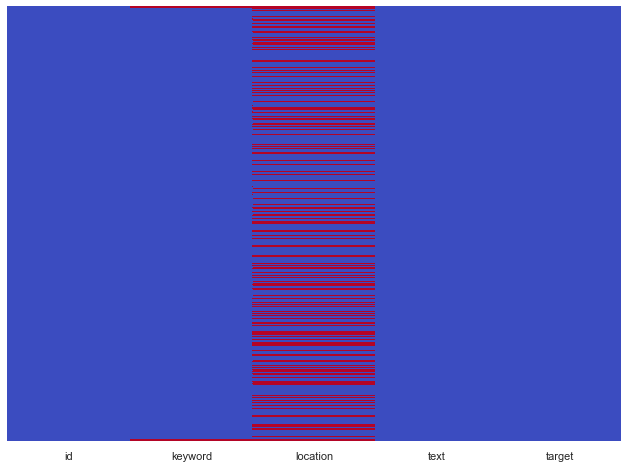

In [19]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='coolwarm')

In [20]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster, 1: Disaster)')

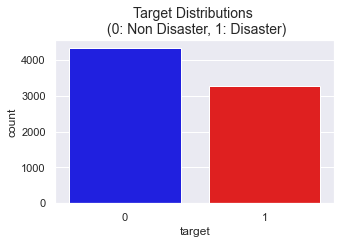

In [21]:
plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x='target', data=train_data, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster, 1: Disaster)', fontsize=14)

In [22]:
train_data["keyword"].nunique()

221

Text(0.5, 0, 'Count of Keyords')

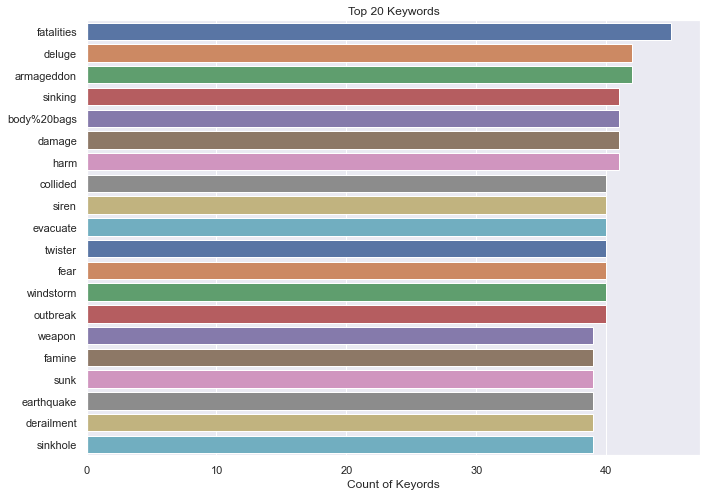

In [23]:
chains = train_data['keyword'].value_counts()[:20]
sns.barplot(x=chains, y=chains.index, palette='deep')
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keyords")

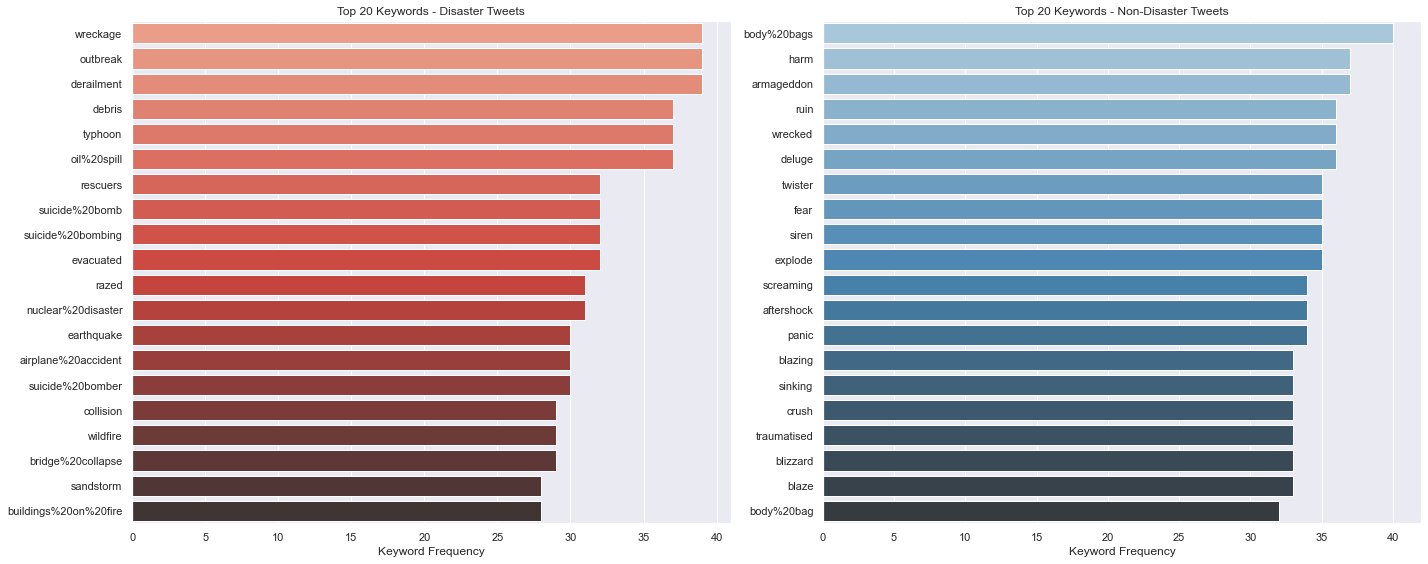

In [24]:
disaster_keywords = train_data.loc[train_data["target"]==1]["keyword"].value_counts()
nondisaster_keywords = train_data.loc[train_data["target"]==0]["keyword"].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")

plt.tight_layout()
plt.show()

In [25]:
top_disaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values(ascending=False).head(20)
top_nondisaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values().head(20)

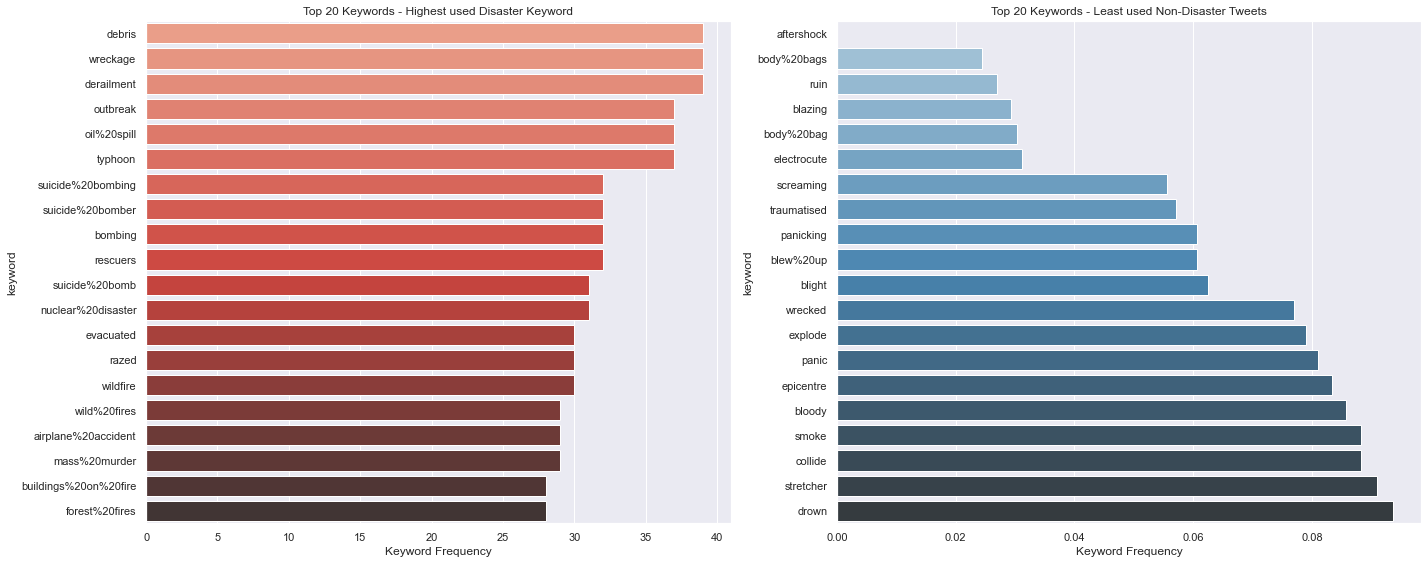

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(y=top_disaster_keyword[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Highest used Disaster Keyword")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=top_nondisaster_keyword[0:20].index, x=top_nondisaster_keyword[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Least used Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

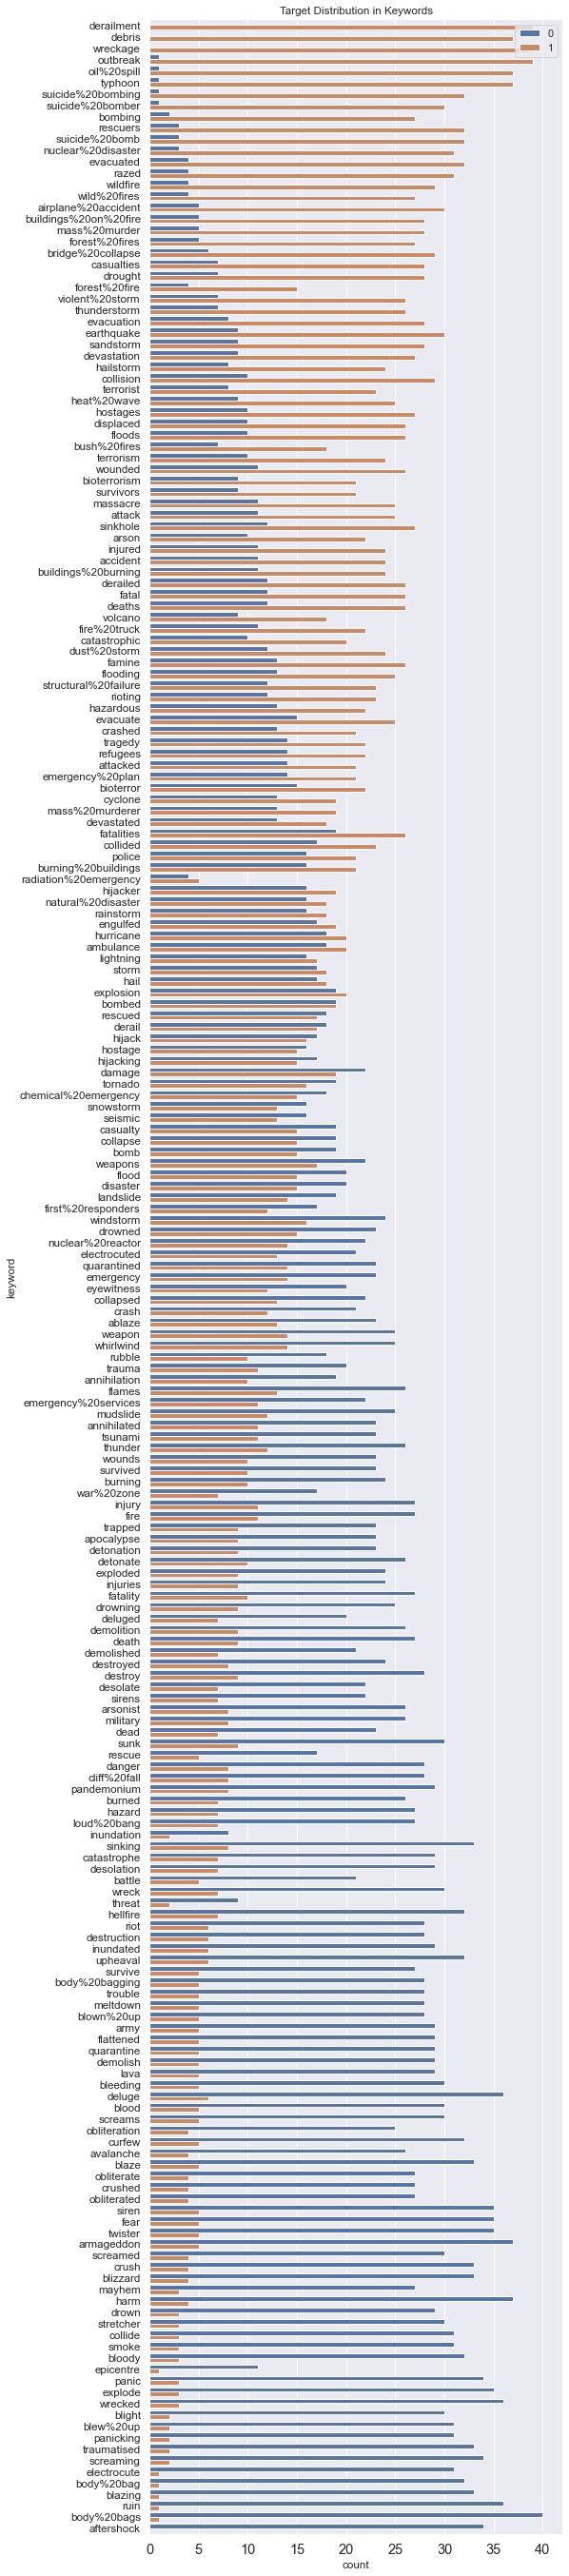

In [27]:
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 50), dpi=70)

sns.countplot(y=train_data.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_data.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_data.drop(columns=['target_mean'], inplace=True)

In [28]:
locations = train_data["location"].value_counts()

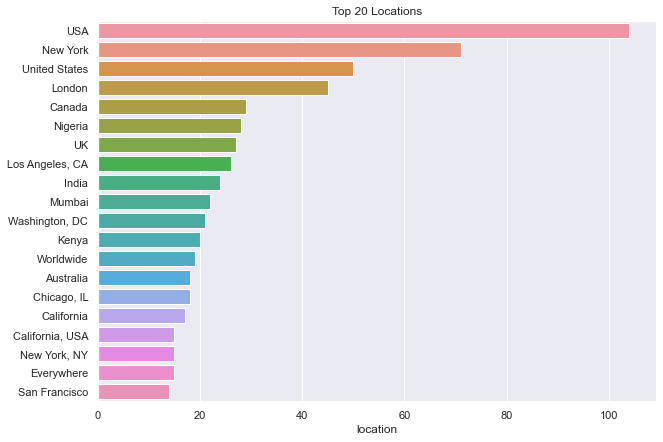

In [29]:
plt.figure(figsize=(10, 7))

sns.barplot(y=locations[0:20].index, x=locations[0:20], orient="h")

plt.title("Top 20 Locations")
plt.show()

In [30]:
print(len(train_data['text']))

7613


In [31]:
train_data["length"] = train_data["text"].apply(len)
train_data.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [32]:
train_data['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [33]:
train_data[train_data['length']==157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

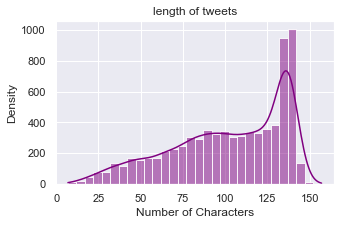

In [34]:
plt.figure(figsize=(5, 3))
sns.histplot(train_data["length"], kde=True, color="purple", bins=30)
plt.title("length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

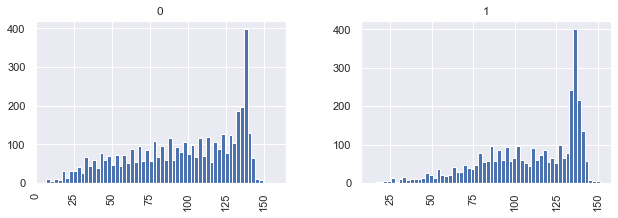

In [35]:
train_data.hist(column="length", by='target', bins=60, figsize=(10,3))

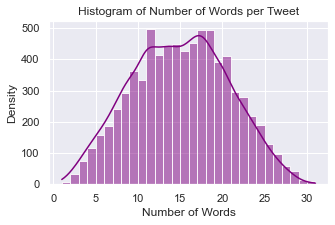

In [36]:
def count_words(x):
    return len(x.split())

train_data["num_words"] = train_data["text"].apply(count_words)

plt.figure(figsize=(5, 3))
sns.histplot(train_data["num_words"], kde=True, color="purple", bins=30)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

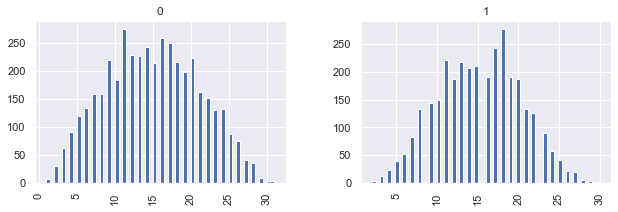

In [37]:
train_data.hist(column='num_words', by='target', bins=60, figsize=(10,3))

### Preprocessing

In [38]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
     "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff differentday",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
     "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [48]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www.\.\S+')
    return url.sub(r'', text)

def remove_HTML(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    return string

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punctuation(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    
    return clean_text

In [49]:
def clean_txt(text):
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    text = replace_abbrev(text)
    text = remove_number(text)
    text = remove_punctuation(text)
    
    return text

In [50]:
train_data['clean_text'] = train_data["text"].apply(clean_txt)

In [51]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [52]:
def to_remove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return remove_stopword

In [53]:
train_data['clean_text'] = train_data['clean_text'].apply(to_remove_stopword)
train_data.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


In [55]:
import numpy as np

In [56]:
negative_words = np.hstack(train_data[train_data['target']==0]['clean_text'].values)
positive_words = np.hstack(train_data[train_data['target']==1]['clean_text'].values)

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('fire', 127), ('via', 119), ('California', 108), ('amp', 107), ('people', 101), ('News', 93), ('killed', 87), ('Hiroshima', 87), ('like', 86), ('suicide', 76), ('disaster', 74), ('fires', 73), ('MH', 71), ('US', 67), ('crash', 66), ('buildings', 66), ('Legionnaires', 62), ('bomb', 61), ('Northern', 60), ('bombing', 60)]
[('like', 235), ('Im', 200), ('amp', 193), ('get', 143), ('dont', 113), ('one', 99), ('via', 94), ('new', 90), ('would', 87), ('know', 81), ('loud', 81), ('people', 79), ('got', 76), ('YouTube', 74), ('back', 73), ('time', 72), ('New', 72), ('video', 71), ('cant', 70), ('see', 70)]


9.572607765209415
8.80469829571626


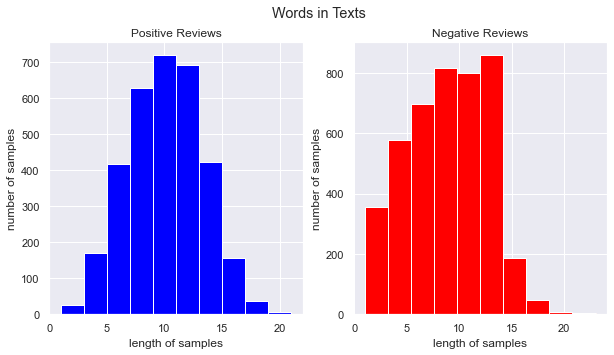

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Words in Texts')

text_len = train_data[train_data['target']==1]['clean_text'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print(np.mean(text_len))

text_len = train_data[train_data['target']==0]['clean_text'].map(lambda x: len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print(np.mean(text_len))

In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['clean_text'])

In [62]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 pair를 key, value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + 1
        
print("vocab size :", total_cnt)
print((threshold-1, rare_cnt))
print((rare_cnt / total_cnt)*100)
print((rare_freq / total_freq)*100)


vocab size : 16749
(1, 10409)
62.146993850379125
14.967933047654656


In [63]:
vocab_size = total_cnt - rare_cnt + 2
print('Vocab_size', vocab_size)

Vocab_size 6342


In [64]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(train_data['clean_text'])
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
print(X[:3])

[[4217, 714, 152, 56, 1430, 4218, 13], [99, 5, 131, 532, 1, 1, 1216], [1553, 1312, 1924, 550, 1, 1554, 153, 1924, 550, 1217, 944]]


23
9.134638119006961


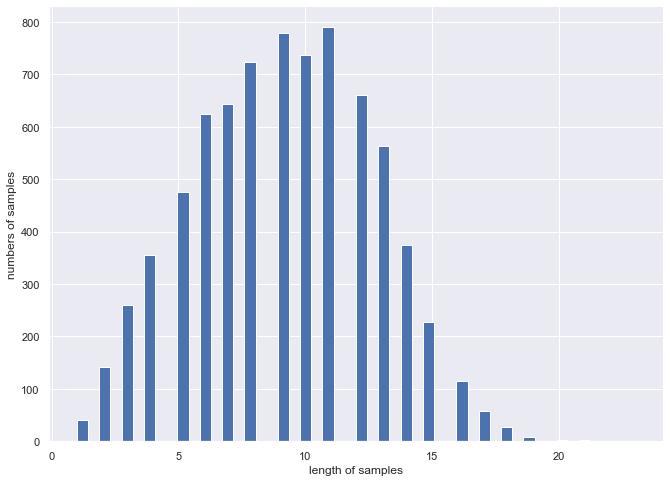

In [65]:
print( max(len(tweet) for tweet in X))
print(sum(map(len, X))/len(X))
plt.hist([len(tweet) for tweet in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('numbers of samples')
plt.show()

In [66]:
max_len = 30
X = pad_sequences(X, maxlen=max_len)
print(X[0])
print(X.shape)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 4217  714  152   56 1430
 4218   13]
(7613, 30)


In [67]:
tokenizer.sequences_to_texts([[4217, 714, 152, 56, 1430, 4218, 13]])

['deeds reason earthquake may allah forgive us']

### LSTM Model Creation

In [68]:
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41)

In [69]:
embed_dim = 64
lstm_out = 64

In [70]:
def build_hybrid_model():
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,), name="input"))
    model.add(layers.Embedding(input_dim=num_features,
                               output_dim=150,
                               input_length=MAX_SEQUENCE_LENGTH))
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01), 
                            bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(64, recurrent_dropout=0.5, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),
                          bias_regularizer=l2(0.01)))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    return model

In [71]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01), 
                        bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4)))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.003)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.hs', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 64)            405888    
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            6176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 1

In [74]:
history = model.fit(X_train, y_train, epochs=4, callbacks=[es, mc], batch_size=32, validation_data=(X_test, y_test))

Epoch 1/4
191/191 [==============================] - 15s 79ms/step - loss: 0.1638 - accuracy: 0.9501 - val_loss: 0.8212 - val_accuracy: 0.7669
Epoch 2/4
191/191 [==============================] - 15s 79ms/step - loss: 0.1442 - accuracy: 0.9563 - val_loss: 0.8391 - val_accuracy: 0.7715
Epoch 3/4
191/191 [==============================] - 16s 83ms/step - loss: 0.1370 - accuracy: 0.9576 - val_loss: 0.8766 - val_accuracy: 0.7551
Epoch 4/4
191/191 [==============================] - 16s 82ms/step - loss: 0.1255 - accuracy: 0.9599 - val_loss: 1.0596 - val_accuracy: 0.7446


In [75]:
y_pred = model.predict(X_test).round()

In [76]:
y_pred

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

### Evaluation

In [77]:
train_accuracy = round(metrics.accuracy_score(y_train, model.predict(X_train).round()) * 100)
train_accuracy

97

In [78]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy  is  :  0.7445830597504924
Recall  is    :  0.7225609756097561
Precision  is :  0.6960352422907489


In [79]:
conm = confusion_matrix(y_test,y_pred)
conm

array([[660, 207],
       [182, 474]], dtype=int64)

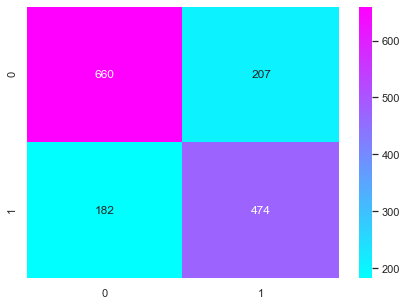

In [80]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       867
           1       0.70      0.72      0.71       656

    accuracy                           0.74      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.74      0.75      1523



### Submission

In [82]:
test_data = pd.read_csv('test.csv')

In [83]:
test_data.head().style.background_gradient(cmap='coolwarm')

,id,keyword,location,text
0,0,nan,nan,Just happened a terrible car crash
1,2,nan,nan,"Heard about #earthquake is different cities, stay safe everyone."
2,3,nan,nan,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,nan,nan,Apocalypse lighting. #Spokane #wildfires
4,11,nan,nan,Typhoon Soudelor kills 28 in China and Taiwan


In [84]:
test_data['clean_text'] = test_data["text"].apply(clean_txt)
test_data['clean_text'].head()

0                  Just happened a terrible car crash 
1    Heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3               Apocalypse lighting Spokane wildfires 
4         Typhoon Soudelor kills  in China and Taiwan 
Name: clean_text, dtype: object

In [85]:
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X, maxlen =l)

In [86]:
tokenizer.fit_on_texts(train_data['clean_text'].values)
test_token = tokenizer.texts_to_sequences(test_data['clean_text'].values)
test_token = pad_sequences(test_token, maxlen =l)

In [87]:
embed_dim = 128
lstm_out = 128

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', 
                        kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4)))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.003)

model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           811776    
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                

In [88]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(X,y, epochs = 10,validation_split = 0.2 ,callbacks=[es_callback], batch_size=32)

Epoch 1/10
191/191 [==============================] - 68s 306ms/step - loss: 0.5983 - accuracy: 0.7197 - val_loss: 0.5001 - val_accuracy: 0.7708
Epoch 2/10
191/191 [==============================] - 48s 252ms/step - loss: 0.3812 - accuracy: 0.8512 - val_loss: 0.5285 - val_accuracy: 0.7820
Epoch 3/10
191/191 [==============================] - 48s 249ms/step - loss: 0.3048 - accuracy: 0.8895 - val_loss: 0.5940 - val_accuracy: 0.7420
Epoch 4/10
191/191 [==============================] - 48s 253ms/step - loss: 0.2638 - accuracy: 0.9107 - val_loss: 0.6826 - val_accuracy: 0.7571


In [93]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv("sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission_DT.csv', index=False)
submission.describe().style.background_gradient(cmap='coolwarm')

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.365308
std,3146.427221,0.481590
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
